In [1]:
import zipfile
import os

zip_path = 'archive (9).zip'
extract_to = 'archive breast cancer'  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler
print("completed")

completed


Total images: 277524
Sample images: ['archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png']
Class0 samples: ['archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'archive breast cancer/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png']
Class1 samples: ['archive 

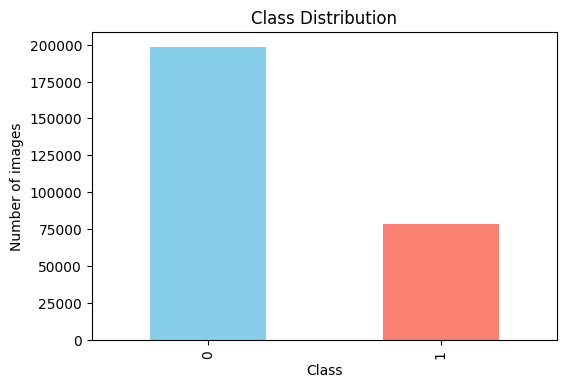

In [66]:
imagePatches = glob.glob("archive breast cancer/IDC_regular_ps50_idx5/**/*.png", recursive=True)
print("Total images:", len(imagePatches))
print("Sample images:", imagePatches[:5])

classZero = [img for img in imagePatches if "class0" in img]
classOne  = [img for img in imagePatches if "class1" in img]
print("Class0 samples:", classZero[:5])
print("Class1 samples:", classOne[:5])

data = pd.DataFrame({
    "image_path": classZero + classOne,
    "label": [0]*len(classZero) + [1]*len(classOne)
})
print("\nDataset head:")
print(data.head())

plt.figure(figsize=(6,4))
data['label'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()




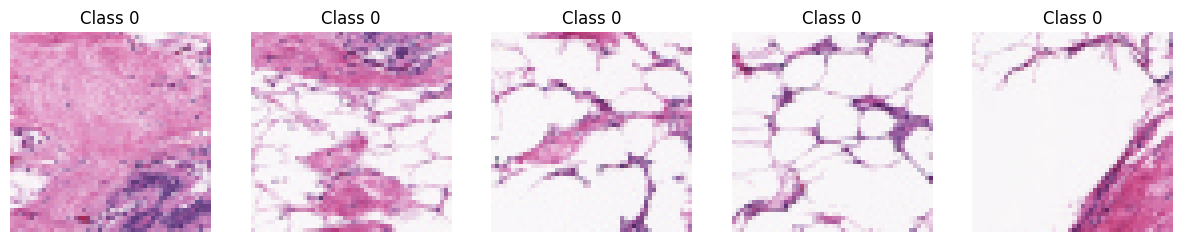

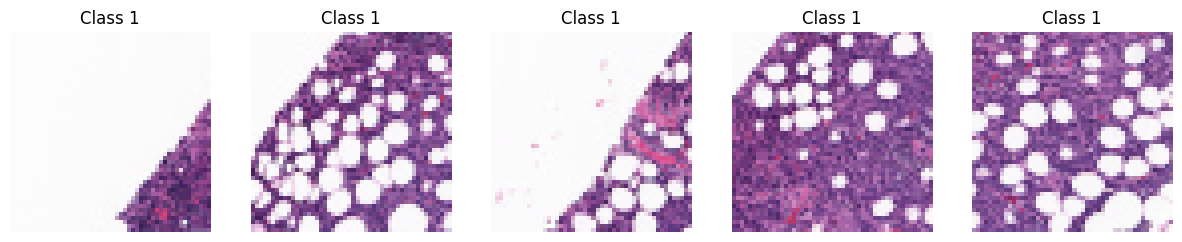

In [4]:
def show_samples(images, label, n=5):
    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(images[:n]):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label}")
    plt.show()

show_samples(classZero, "Class 0")
show_samples(classOne, "Class 1")

In [5]:
class IDCdataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.labels = [0 if "class0" in p else 1 for p in self.image_paths]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
]) 

In [6]:
train_paths, test_paths = train_test_split(imagePatches, test_size=0.2, random_state=42)

train_dataset = IDCdataset(train_paths, transform=train_transform)
test_dataset = IDCdataset(test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 222019
Test dataset size: 55505


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  
model = model.to(device)


C:\Users\sayak\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

y_train_labels = [0 if "class0" in p else 1 for p in train_paths] 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels) 
weights = torch.tensor(class_weights, dtype=torch.float).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights) 
optimizer = optim.Adam(model.parameters(), lr=1e-4)



In [9]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()*images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss/total
        train_acc = correct/total
        

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss /= val_total
        val_acc = val_correct/val_total
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    return history

history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=8)


Epoch 1/8: 100%|███████████████████████████████████████████████████████████████████| 3470/3470 [52:50<00:00,  1.09it/s]


Epoch 1: Train Acc=0.8495, Val Acc=0.8854, Train Loss=0.3546, Val Loss=0.3191


Epoch 2/8: 100%|█████████████████████████████████████████████████████████████████| 3470/3470 [1:13:07<00:00,  1.26s/it]


Epoch 2: Train Acc=0.8690, Val Acc=0.8718, Train Loss=0.3098, Val Loss=0.2906


Epoch 3/8: 100%|█████████████████████████████████████████████████████████████████| 3470/3470 [1:09:40<00:00,  1.20s/it]


Epoch 3: Train Acc=0.8750, Val Acc=0.8896, Train Loss=0.2950, Val Loss=0.2944


Epoch 4/8: 100%|███████████████████████████████████████████████████████████████████| 3470/3470 [59:44<00:00,  1.03s/it]


Epoch 4: Train Acc=0.8787, Val Acc=0.8756, Train Loss=0.2855, Val Loss=0.2885


Epoch 5/8: 100%|█████████████████████████████████████████████████████████████████| 3470/3470 [1:12:30<00:00,  1.25s/it]


Epoch 5: Train Acc=0.8816, Val Acc=0.8788, Train Loss=0.2771, Val Loss=0.2785


Epoch 6/8: 100%|█████████████████████████████████████████████████████████████████| 3470/3470 [1:18:19<00:00,  1.35s/it]


Epoch 6: Train Acc=0.8865, Val Acc=0.8673, Train Loss=0.2683, Val Loss=0.2844


Epoch 7/8: 100%|███████████████████████████████████████████████████████████████████| 3470/3470 [57:52<00:00,  1.00s/it]


Epoch 7: Train Acc=0.8881, Val Acc=0.8929, Train Loss=0.2615, Val Loss=0.2707


Epoch 8/8: 100%|█████████████████████████████████████████████████████████████████| 3470/3470 [1:03:19<00:00,  1.09s/it]


Epoch 8: Train Acc=0.8918, Val Acc=0.8970, Train Loss=0.2558, Val Loss=0.2732


Classification Report:
               precision    recall  f1-score   support

      IDC(-)       0.95      0.91      0.93     39866
      IDC(+)       0.79      0.87      0.83     15639

    accuracy                           0.90     55505
   macro avg       0.87      0.89      0.88     55505
weighted avg       0.90      0.90      0.90     55505



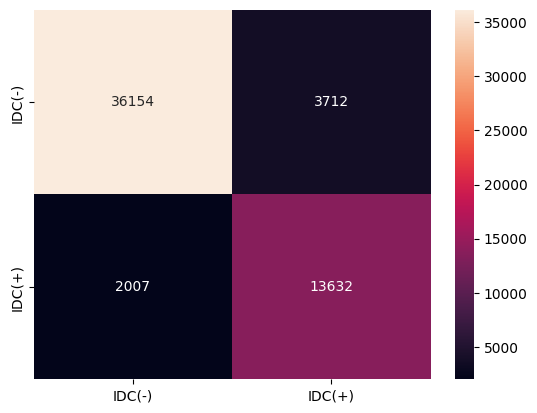

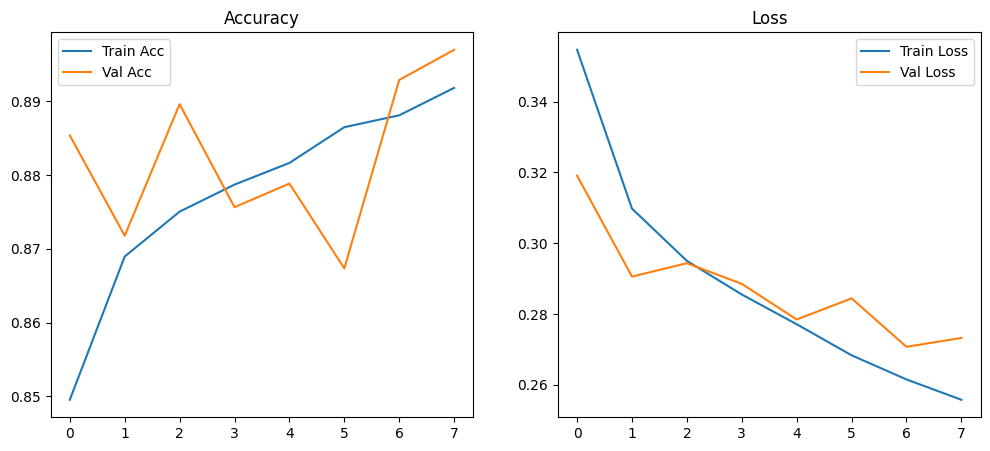

In [11]:

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  
        _, predicted = outputs.max(1)  
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['IDC(-)', 'IDC(+)']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['IDC(-)', 'IDC(+)'], yticklabels=['IDC(-)', 'IDC(+)'])
plt.show()


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [23]:
# After training the model
torch.save(model.state_dict(), 'resnet18_idc_model.pth')
print("Model saved to 'resnet18_idc_model.pth'")

Model saved to 'resnet18_idc_model.pth'


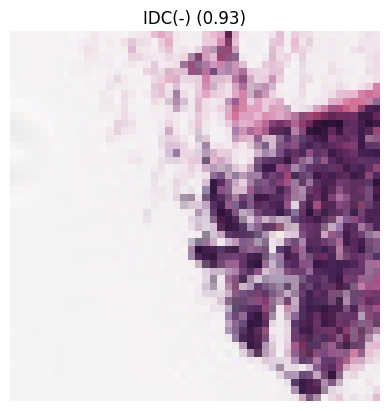

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.025641024..1.391453].


Prediction: IDC(-)
Confidence: 0.9318
Class probabilities [IDC(-), IDC(+)]: [[0.9318046  0.06819538]]


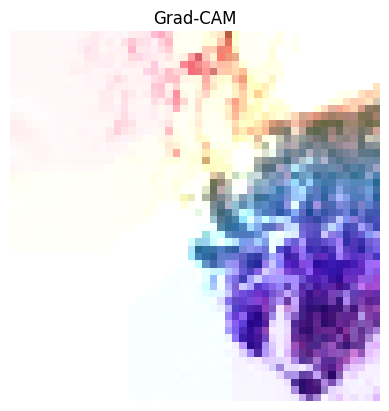

In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Same preprocessing transform as before
test_transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


model = models.resnet18(weights=None)  
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("resnet18_idc_model.pth", map_location=device))
model = model.to(device)
model.eval()

def predict_new_image(model, image_path, transform=test_transform):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        prob = probs[0][pred_class].item()

    label = "IDC(+)" if pred_class == 1 else "IDC(-)"
    

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({prob:.2f})")
    plt.show()

    return img_tensor, label, prob, probs.cpu().numpy()


def grad_cam(model, image_tensor, class_idx=None):
    model.eval()
    features = []
    gradients = []

    def save_features(module, input, output):
        features.append(output)

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])


    target_layer = model.layer4[1].conv2
    target_layer.register_forward_hook(save_features)
    target_layer.register_full_backward_hook(save_gradients)

 
    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()


    model.zero_grad()
    output[0, class_idx].backward()


    grad = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]

    
    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (50,50))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

   
    img = image_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = 0.4 * heatmap + img

    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()


# grad cam
image_path = "9382_idx5_x51_y1801_class0.png"  
img_tensor, label, prob, all_probs = predict_new_image(model, image_path)
print(f"Prediction: {label}")
print(f"Confidence: {prob:.4f}")
print(f"Class probabilities [IDC(-), IDC(+)]: {all_probs}")


def grad_cam_with_boxes(model, image_tensor, original_img, class_idx=None, threshold=0.5):
    model.eval()
    features, gradients = [], []

    def save_features(module, input, output):
        features.append(output)

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

  
    target_layer = model.layer4[1].conv2
    target_layer.register_forward_hook(save_features)
    target_layer.register_full_backward_hook(save_gradients)

   
    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()
    model.zero_grad()
    output[0, class_idx].backward()

  
    grad = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]
    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (original_img.size[0], original_img.size[1]))
    cam = cam / cam.max()

    mask = np.uint8(cam > threshold) * 255


    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    img_cv = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR)

   
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), (0, 255, 0), 1)  # thickness=1

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Important Regions (Grad-CAM Bounding Boxes, Thin)")
    plt.show()

grad_cam(model, img_tensor)



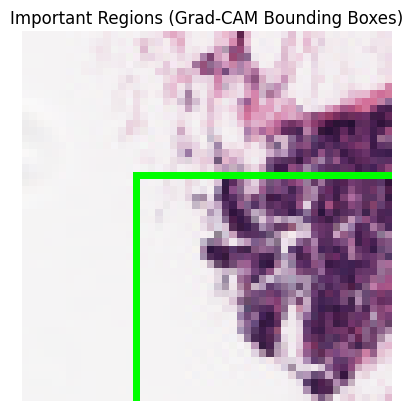

In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_transform = transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("resnet18_idc_model.pth", map_location=device))
model = model.to(device)
model.eval()


def predict_new_image(model, image_path, transform=test_transform):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img, img_tensor


def grad_cam_with_boxes(model, image_tensor, original_img, class_idx=None, threshold=0.5):
    model.eval()
    features, gradients = [], []

    def save_features(module, input, output):
        features.append(output)

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

  
    target_layer = model.layer4[1].conv2
    target_layer.register_forward_hook(save_features)
    target_layer.register_full_backward_hook(save_gradients)

  
    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()
    model.zero_grad()
    output[0, class_idx].backward()

    
    grad = gradients[0].cpu().data.numpy()[0]
    fmap = features[0].cpu().data.numpy()[0]
    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (original_img.size[0], original_img.size[1]))
    cam = cam / cam.max()

  
    mask = np.uint8(cam > threshold) * 255


    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  
    img_cv = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR)

    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), (0, 255, 0), 1)  # thickness=1

  
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Important Regions (Grad-CAM Bounding Boxes)")
    plt.show()



image_path = "9382_idx5_x51_y1801_class0.png" 
orig_img, img_tensor = predict_new_image(model, image_path)

grad_cam_with_boxes(model, img_tensor, orig_img, threshold=0.6)
